# Delivery Time Prediction

Based on the DoorDash dataset 

Assignment: https://platform.stratascratch.com/data-projects/delivery-duration-prediction

## Setup

In [2]:
import pandas as pd
import numpy as np
	
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px

## EDA

### Data Import

Lets take our first look on dataset

In [3]:
eda_df = pd.read_csv("datasets/historical_data.csv")
eda_df.head()

market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

In [4]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Before starting EDA, lets devide dataset into train and validation sets and leave validation set for better times


### Handling Missing Values

In [5]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [6]:
for feature in eda_df.columns:
    if eda_df.shape[0] - eda_df[feature].notnull().sum() != 0:
        print(f"{feature} - {eda_df.shape[0] - eda_df[feature].notnull().sum()} missing values")

market_id - 987 missing values
actual_delivery_time - 7 missing values
store_primary_category - 4760 missing values
order_protocol - 995 missing values
total_onshift_dashers - 16262 missing values
total_busy_dashers - 16262 missing values
total_outstanding_orders - 16262 missing values
estimated_store_to_consumer_driving_duration - 526 missing values


From previous cell we can define, that there are 6 features, which have missing values:
- `market_id` - 689 missing values
- `store_primary_category` - 3362 missing values
- `order_protocol` - 694 missing values
- `total_onshift_dashers` - 11422 missing values
- `total_busy_dashers` - 11422 missing values
- `total_outstanding_orders` - 11422 missing values
- `estimated_store_to_consumer_driving_duration` - 366 missing values
- `delivery_duration` - 6 missing values

For this features it will be hard to find an optimal way to impute them, so we will just delete all records with missing values

In [7]:
eda_df.dropna(axis="rows", inplace=True)
eda_df

market_id           created_at actual_delivery_time  store_id  \
0             1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1             2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
8             2.0  2015-02-16 00:11:35  2015-02-16 00:38:01      5477   
14            1.0  2015-02-12 03:36:46  2015-02-12 04:14:39      2841   
15            1.0  2015-01-27 02:12:36  2015-01-27 03:02:24      2841   
...           ...                  ...                  ...       ...   
197423        1.0  2015-02-17 00:19:41  2015-02-17 01:24:48      2956   
197424        1.0  2015-02-13 00:01:59  2015-02-13 00:58:22      2956   
197425        1.0  2015-01-24 04:46:08  2015-01-24 05:36:16      2956   
197426        1.0  2015-02-01 18:18:15  2015-02-01 19:23:22      3630   
197427        1.0  2015-02-08 19:24:33  2015-02-08 20:01:41      3630   

       store_primary_category  order_protocol  total_items  subtotal  \
0                    american             1.0            4      3441   
1                     mexican             2.0            1      1900   
8                      indian             3.0            4      4771   
14                    italian             1.0            1      1525   
15                    italian             1.0            2      3620   
...                       ...             ...          ...       ...   
197423                   fast             4.0            3      1389   
197424                   fast             4.0            6      3010   
197425                   fast             4.0            5      1836   
197426               sandwich             1.0            1      1175   
197427               sandwich             1.0            4      2605   

        num_distinct_items  min_item_price  max_item_price  \
0                        4             557            1239   
1                        1            1400            1400   
8                        3             820            1604   
14                       1            1525            1525   
15                       2            1425            2195   
...                    ...             ...             ...   
197423                   3             345             649   
197424                   4             405             825   
197425                   3             300             399   
197426                   1             535             535   
197427                   4             425             750   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                        33.0                14.0                      21.0   
1                         1.0                 2.0                       2.0   
8                         8.0                 6.0                      18.0   
14                        5.0                 6.0                       8.0   
15                        5.0                 5.0                       7.0   
...                       ...                 ...                       ...   
197423                   17.0                17.0                      23.0   
197424                   12.0                11.0                      14.0   
197425                   39.0                41.0                      40.0   
197426                    7.0                 7.0                      12.0   
197427                   20.0                20.0                      23.0   

        estimated_order_place_duration  \
0                                  446   
1                                  446   
8                                  446   
14                                 446   
15                                 446   
...                                ...   
197423                             251   
197424                             251   
197425                             251   
197426                             446   
197427                             446   

        estimated_store_to_consumer_driving_duration  
0           

### Data Description

Next step will be defining types of features. We need to define, which features will be numerical, categorical or timestamps.

Categorical features:
- `market_id`
- `store_id`
- `store_primary_category`
- `order_protocol`

TimeStamps:
- `created_at`
- `actual_delivery_time`

All other features are numerical features


In [8]:
eda_df["market_id"] = eda_df["market_id"].astype("object")
eda_df["store_id"] = eda_df["store_id"].astype("object")
eda_df["store_primary_category"] = eda_df["store_primary_category"].astype("object")
eda_df["order_protocol"] = eda_df["order_protocol"].astype("object")

eda_df["created_at"] = eda_df["created_at"].astype("datetime64[s]")
eda_df["actual_delivery_time"] = eda_df["actual_delivery_time"].astype("datetime64[s]")

time_features = ["created_at", "actual_delivery_time"]
categorical_features = ["market_id", "store_id", "store_primary_category", "order_protocol" ]
numerical_features = eda_df.drop(categorical_features, axis="columns").drop(time_features, axis="columns").columns


In [9]:
eda_df.describe()

created_at actual_delivery_time    total_items       subtotal  \
count               175777               175777  175777.000000  175777.000000   
mean   2015-02-04 19:57:50  2015-02-04 20:45:36       3.204976    2697.111147   
min    2015-01-21 15:22:03  2015-01-21 16:16:34       1.000000       0.000000   
25%    2015-01-29 01:31:19  2015-01-29 02:18:30       2.000000    1412.000000   
50%    2015-02-05 02:41:26  2015-02-05 03:45:31       3.000000    2224.000000   
75%    2015-02-12 01:04:32  2015-02-12 01:47:32       4.000000    3410.000000   
max    2015-02-18 06:00:44  2015-02-19 22:45:31     411.000000   26800.000000   
std                    NaN                  NaN       2.674055    1828.554893   

       num_distinct_items  min_item_price  max_item_price  \
count       175777.000000   175777.000000   175777.000000   
mean             2.675060      684.965433     1160.158616   
min              1.000000      -86.000000        0.000000   
25%              1.000000      299.000000      799.000000   
50%              2.000000      595.000000     1095.000000   
75%              3.000000      942.000000     1395.000000   
max             20.000000    14700.000000    14700.000000   
std              1.625681      519.882924      560.828571   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
count          175777.000000       175777.000000             175777.000000   
mean               44.918664           41.861381                 58.230115   
min                -4.000000           -5.000000                 -6.000000   
25%                17.000000           15.000000                 17.000000   
50%                37.000000           35.000000                 41.000000   
75%                66.000000           63.000000                 85.000000   
max               171.000000          154.000000                285.000000   
std                34.544724           32.168505                 52.731043   

       estimated_order_place_duration  \
count                   175777.000000   
mean                       307.818105   
min                          0.000000   
25%                        251.000000   
50%                        251.000000   
75%                        446.000000   
max                       2715.000000   
std                         89.796587   

       estimated_store_to_consumer_driving_duration  
count                                 175777.000000  
mean                                     546.077240  
min                                        0.000000  
25%                                      384.000000  
50%                                      544.000000  
75%                                      703.000000  
max                                     2088.000000  
std                                      218.717798

In [10]:
for column in eda_df.columns:
	if eda_df[column].dtype == object:
		print(eda_df[column].value_counts())

market_id
2.0    53469
4.0    46222
1.0    37115
3.0    21075
5.0    17258
6.0      638
Name: count, dtype: int64
store_id
6865    923
1311    849
314     805
1686    754
3937    711
       ... 
3449      1
6470      1
5364      1
2198      1
6376      1
Name: count, Length: 5645, dtype: int64
store_primary_category
american             18183
pizza                15745
mexican              15586
burger                9915
sandwich              8995
                     ...  
african                 10
lebanese                 9
belgian                  2
chocolate                1
alcohol-plus-food        1
Name: count, Length: 73, dtype: int64
order_protocol
1.0    48404
3.0    47125
5.0    41415
2.0    20890
4.0    17246
6.0      678
7.0       19
Name: count, dtype: int64


One thing, that we can already notice, is that some of objects have negative values for some attributes, which cant be negative (like `min_item_price`, `total_onshift_dashers`). Generally, none of the features we have in this dataset cant be negative, so we can delete this objects, because there are errors in them

In [11]:
for feature in numerical_features:
    eda_df = eda_df[eda_df[feature] > 0]

### Data Visualization

#### Numerical Features

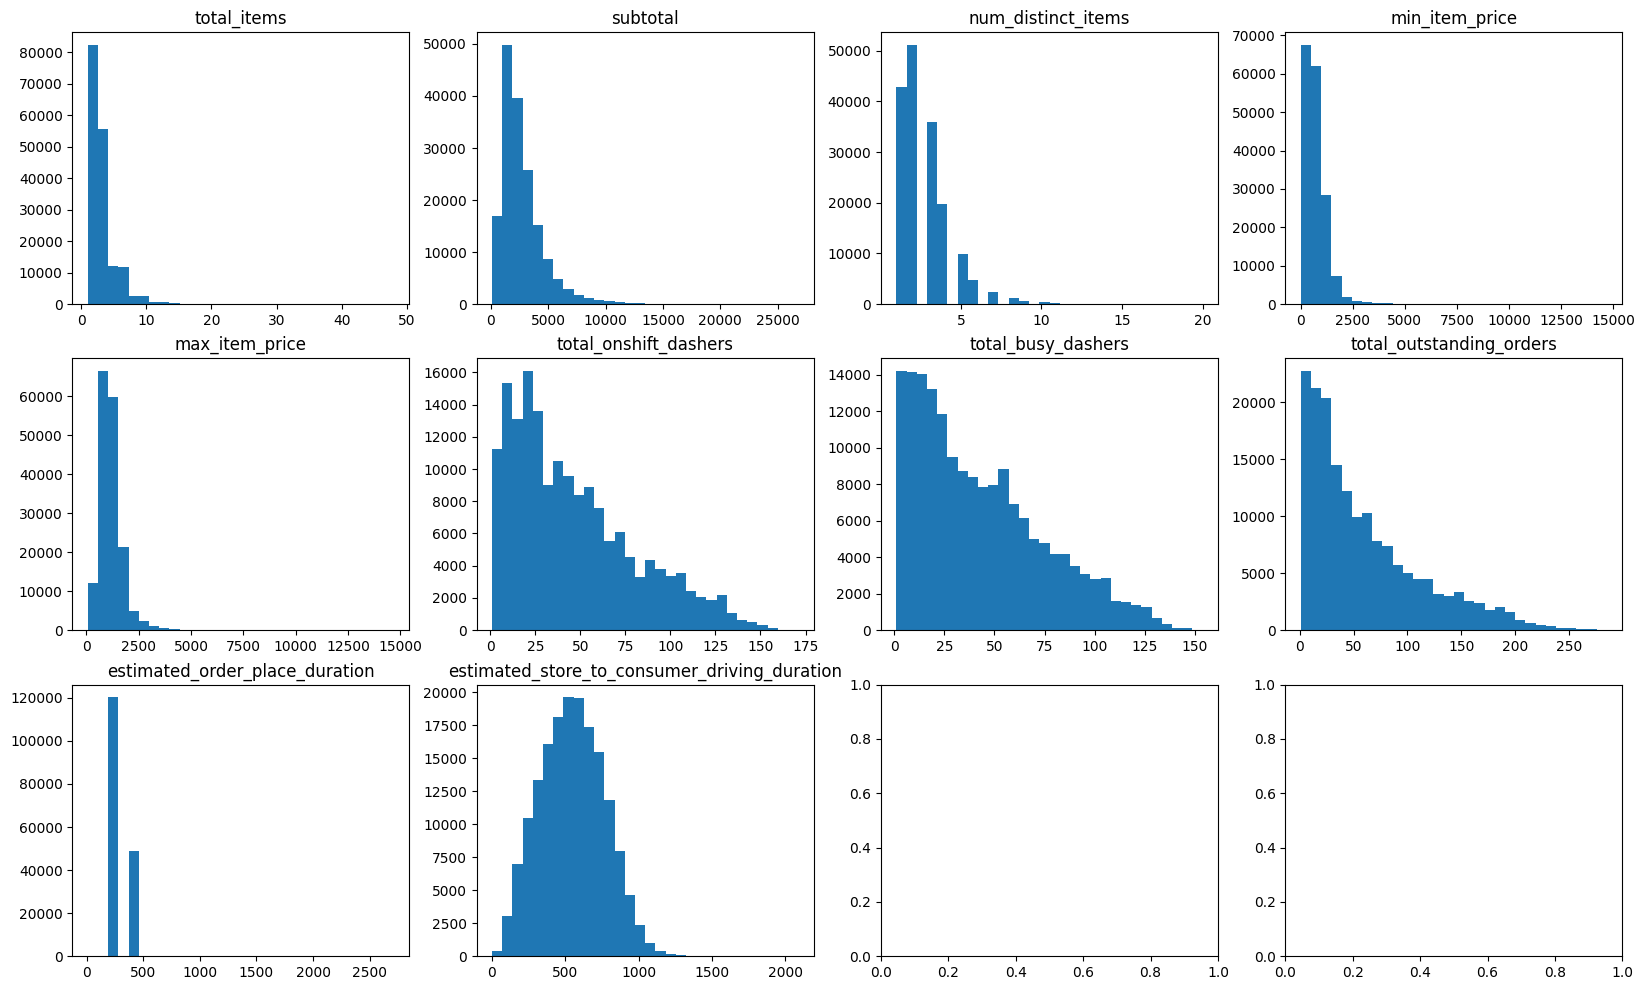

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))

i = 0
for feature in numerical_features:
    axs[i // 4, i % 4].hist(eda_df[feature], bins=30)
    axs[i // 4, i % 4].set_title(feature)
    i += 1

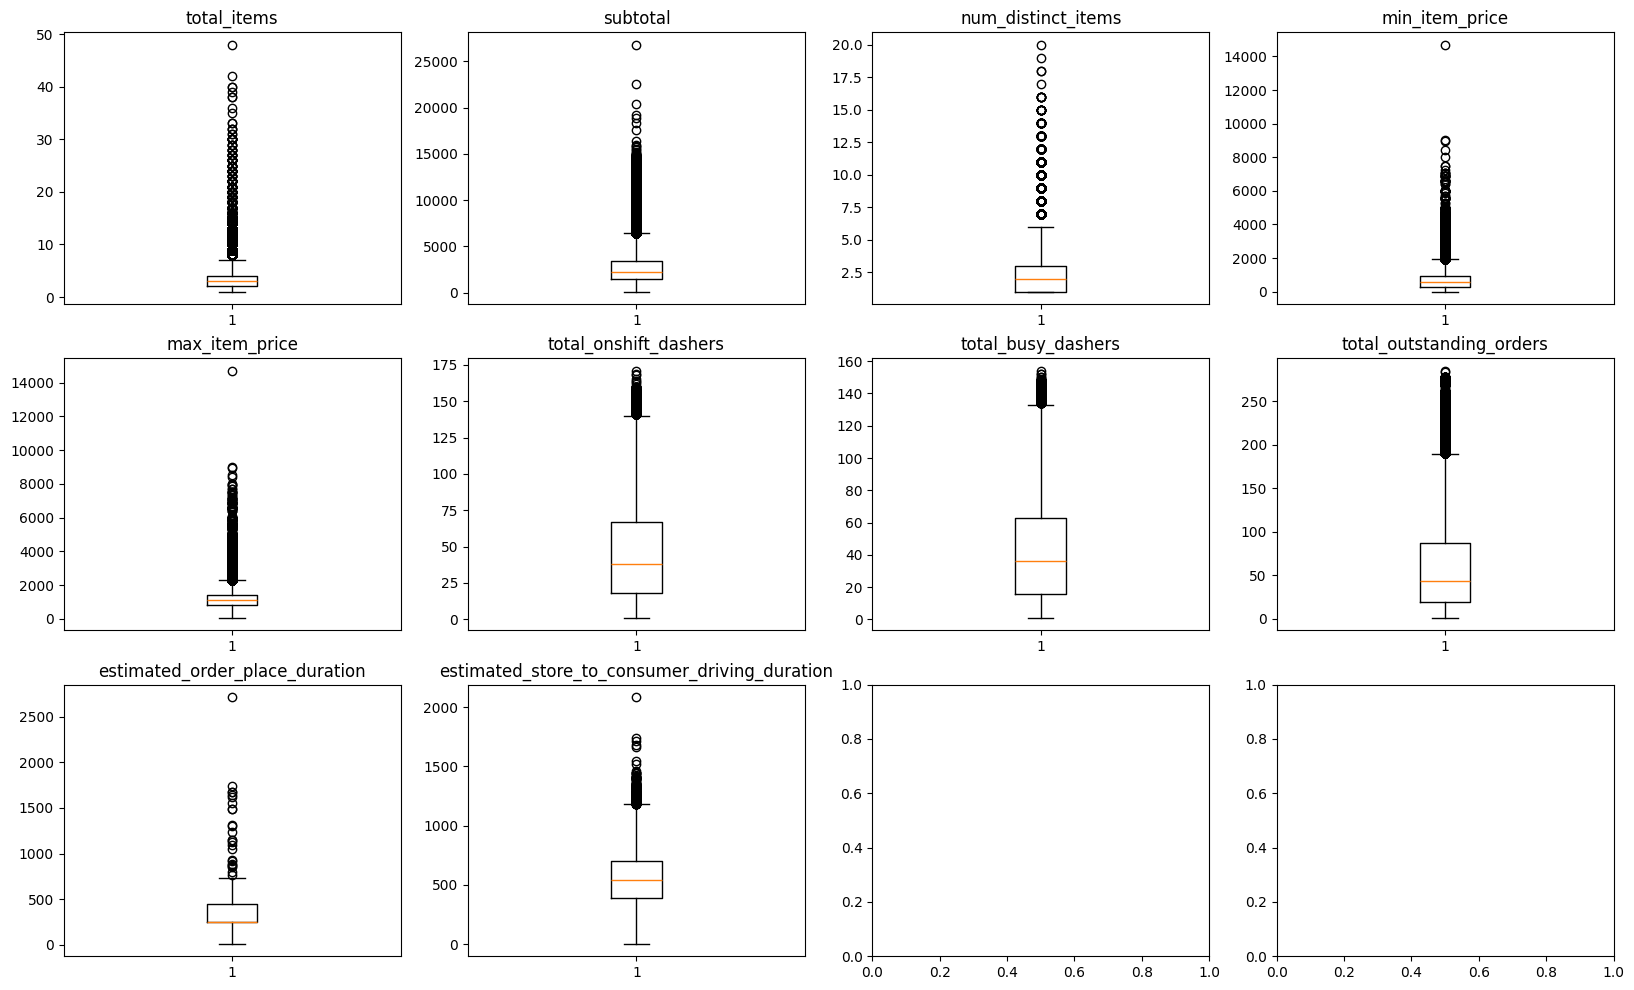

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))

i = 0
for feature in numerical_features:
    axs[i // 4, i % 4].boxplot(eda_df[feature])
    axs[i // 4, i % 4].set_title(feature)
    i += 1

As we can see from histograms, data on most of numerical feataures has right-skewed distribution. So we can use logarithmical transformation for all atribute except of `estimated_store_to_consumer_driving_duration` (because it already looks normal), in order to make distribution closer to normal

Also we have outliers in our data, but this outliers are not errors, they are just rare big orders, so we will not delete them or inpute. In future, we will just choose model, which is not affected to outliers, like for example, Random Forest

In [14]:
temp = eda_df.copy()

for feature in numerical_features:
   if feature !=  "estimated_store_to_consumer_driving_duration" :
       	temp[feature] = temp[feature].apply(lambda x : np.log(x))

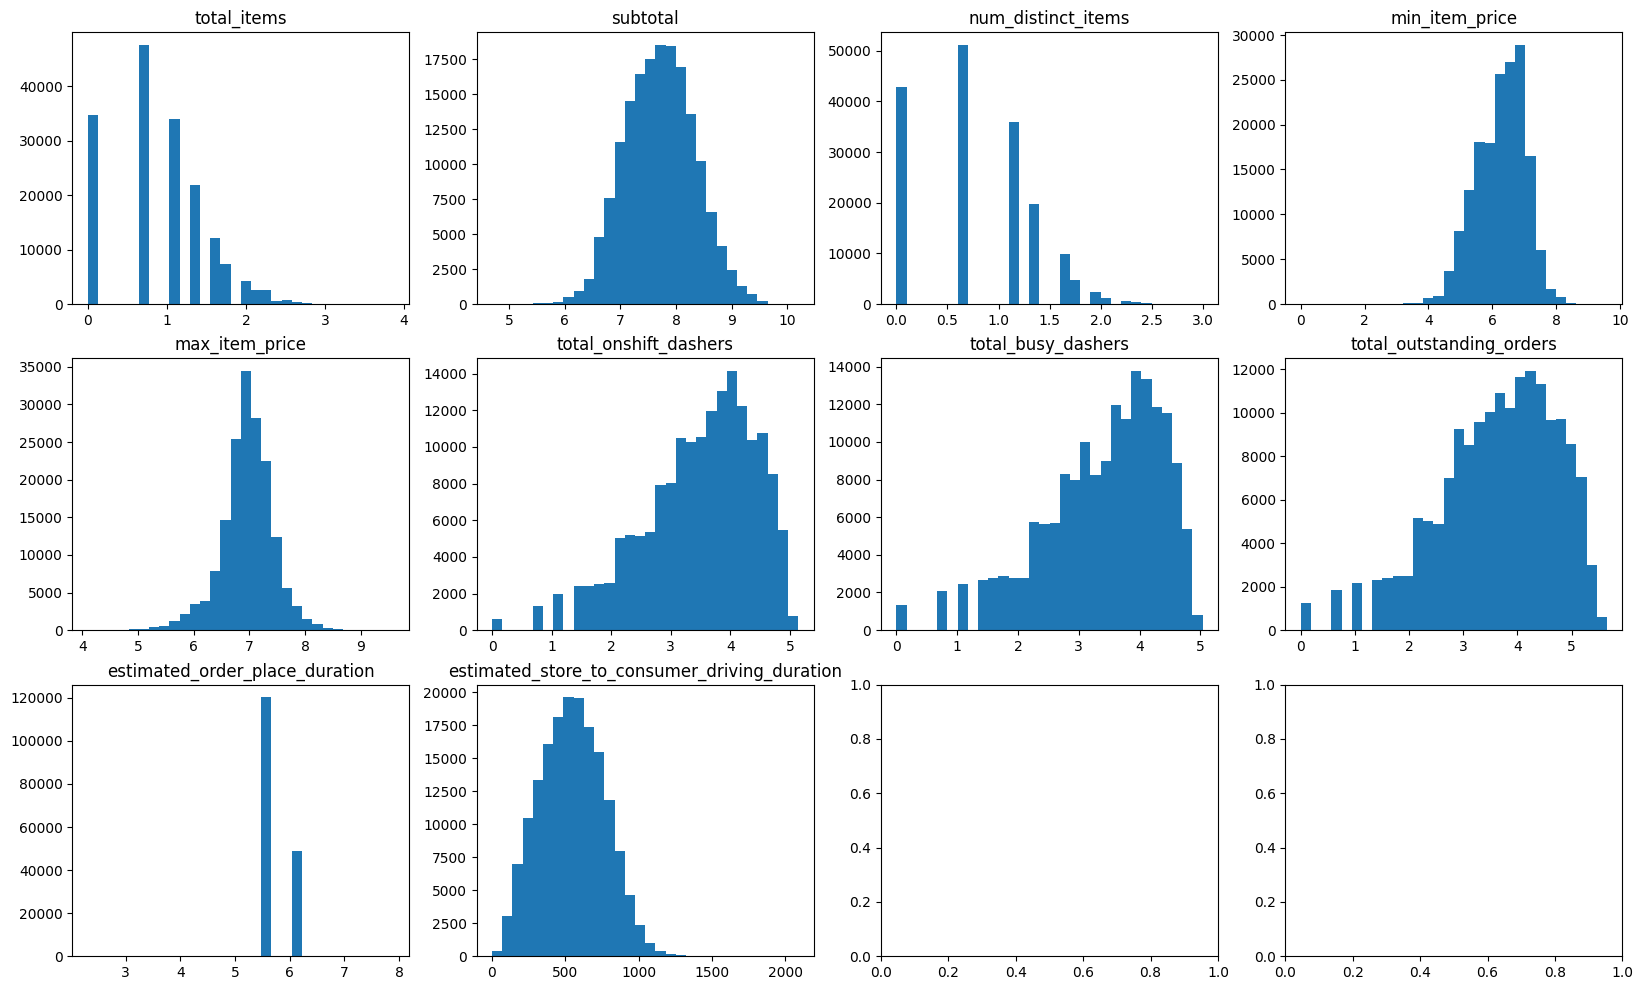

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))

i = 0
for feature in numerical_features:
    axs[i // 4, i % 4].hist(temp[feature], bins=30)
    axs[i // 4, i % 4].set_title(feature)
    i += 1

Now, we can see, that data distribution now is closer to normal, so can go to categorical data.

#### Categorical Features

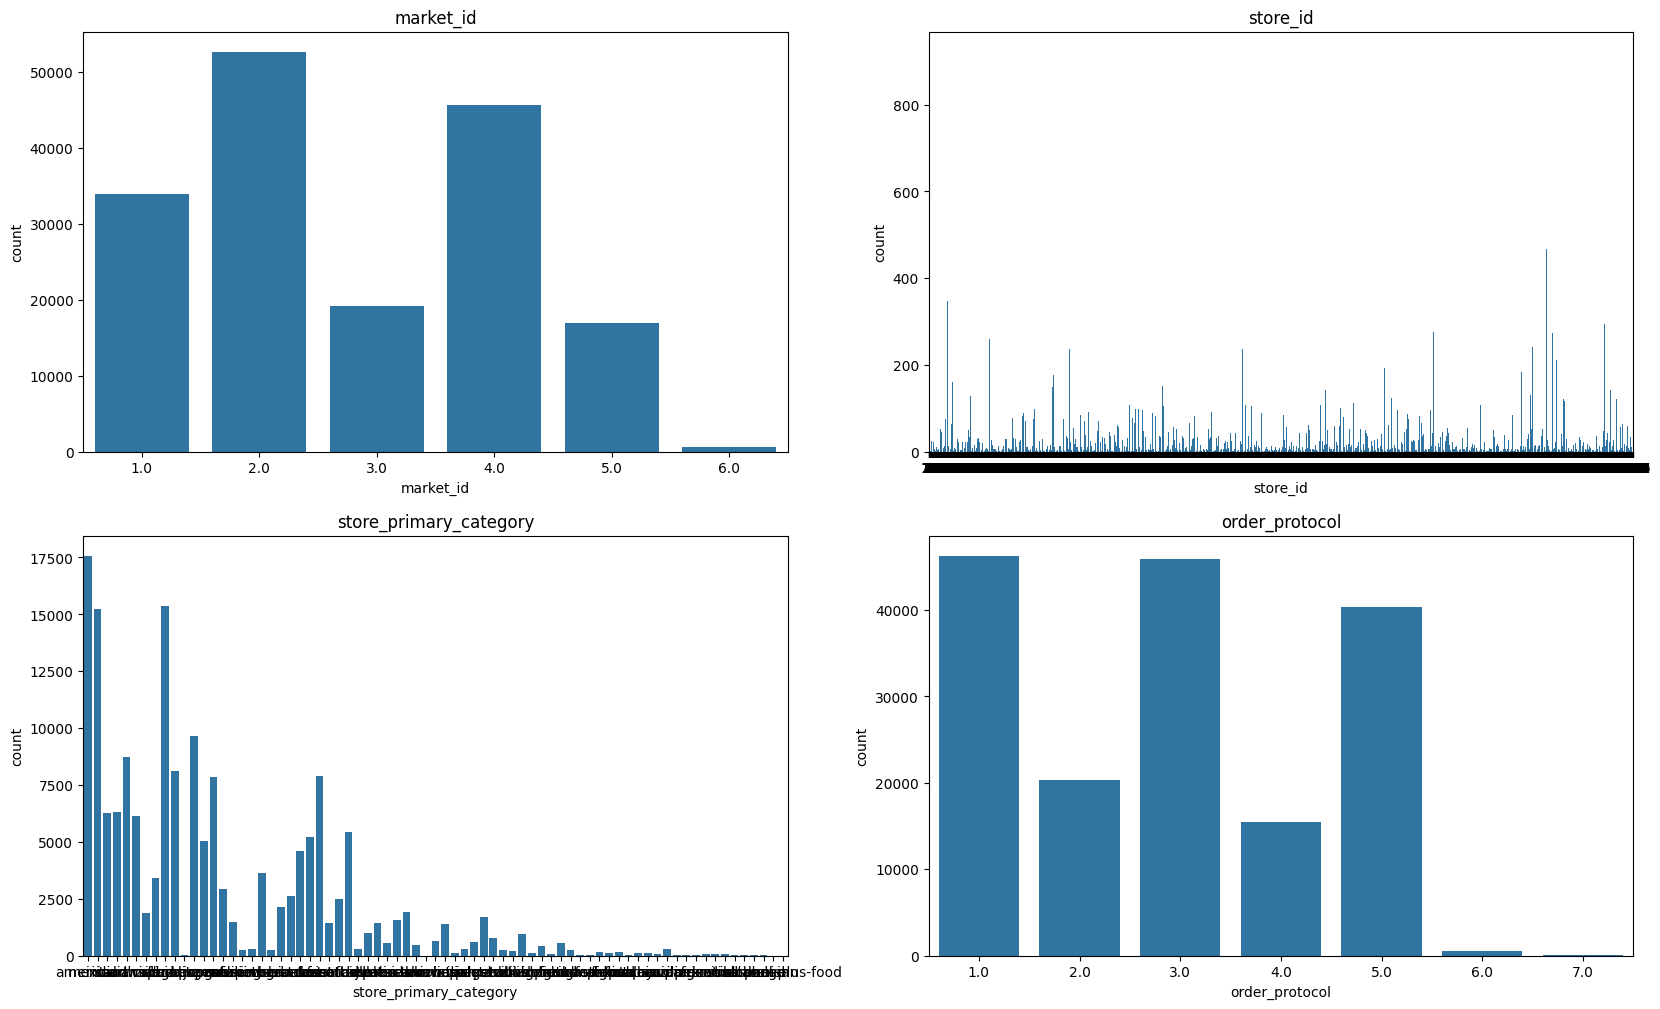

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

i = 0
for feature in categorical_features:
    sns.countplot(ax=axs[i // 2, i % 2], data=eda_df, x=feature)
    axs[i // 2, i % 2].set_title(feature)
    i += 1

### Feature Building and Corelations

In order to quikly check correlations between features, we can build pair plot for all numerical features using mtplotlib

In [17]:
eda_df.head()

market_id          created_at actual_delivery_time store_id  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16     1845   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29     5477   
8        2.0 2015-02-16 00:11:35  2015-02-16 00:38:01     5477   
14       1.0 2015-02-12 03:36:46  2015-02-12 04:14:39     2841   
15       1.0 2015-01-27 02:12:36  2015-01-27 03:02:24     2841   

   store_primary_category order_protocol  total_items  subtotal  \
0                american            1.0            4      3441   
1                 mexican            2.0            1      1900   
8                  indian            3.0            4      4771   
14                italian            1.0            1      1525   
15                italian            1.0            2      3620   

    num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                    4             557            1239                   33.0   
1                    1            1400            1400                    1.0   
8                    3             820            1604                    8.0   
14                   1            1525            1525                    5.0   
15                   2            1425            2195                    5.0   

    total_busy_dashers  total_outstanding_orders  \
0                 14.0                      21.0   
1                  2.0                       2.0   
8                  6.0                      18.0   
14                 6.0                       8.0   
15                 5.0                       7.0   

    estimated_order_place_duration  \
0                              446   
1                              446   
8                              446   
14                             446   
15                             446   

    estimated_store_to_consumer_driving_duration  
0                                          861.0  
1                                          690.0  
8                                          289.0  
14                                         795.0  
15                                         205.0

In this section, we will check correlation between features and target. But before it, we need to create feature for target. As we are predicting delivery time, target feature will be difference between `actual_delivery_time` and `created_at`

In [18]:
eda_df["total_delivery_time"] = (eda_df["actual_delivery_time"] - eda_df["created_at"]).apply(lambda x : x.seconds)
numerical_features = pd.Index(list(numerical_features) + ["total_delivery_time"])
eda_df["total_delivery_time"]

0         3779
1         4024
8         1586
14        2273
15        2988
          ... 
197423    3907
197424    3383
197425    3008
197426    3907
197427    2228
Name: total_delivery_time, Length: 169007, dtype: int64

In [19]:
len(numerical_features)

11

<Axes: >

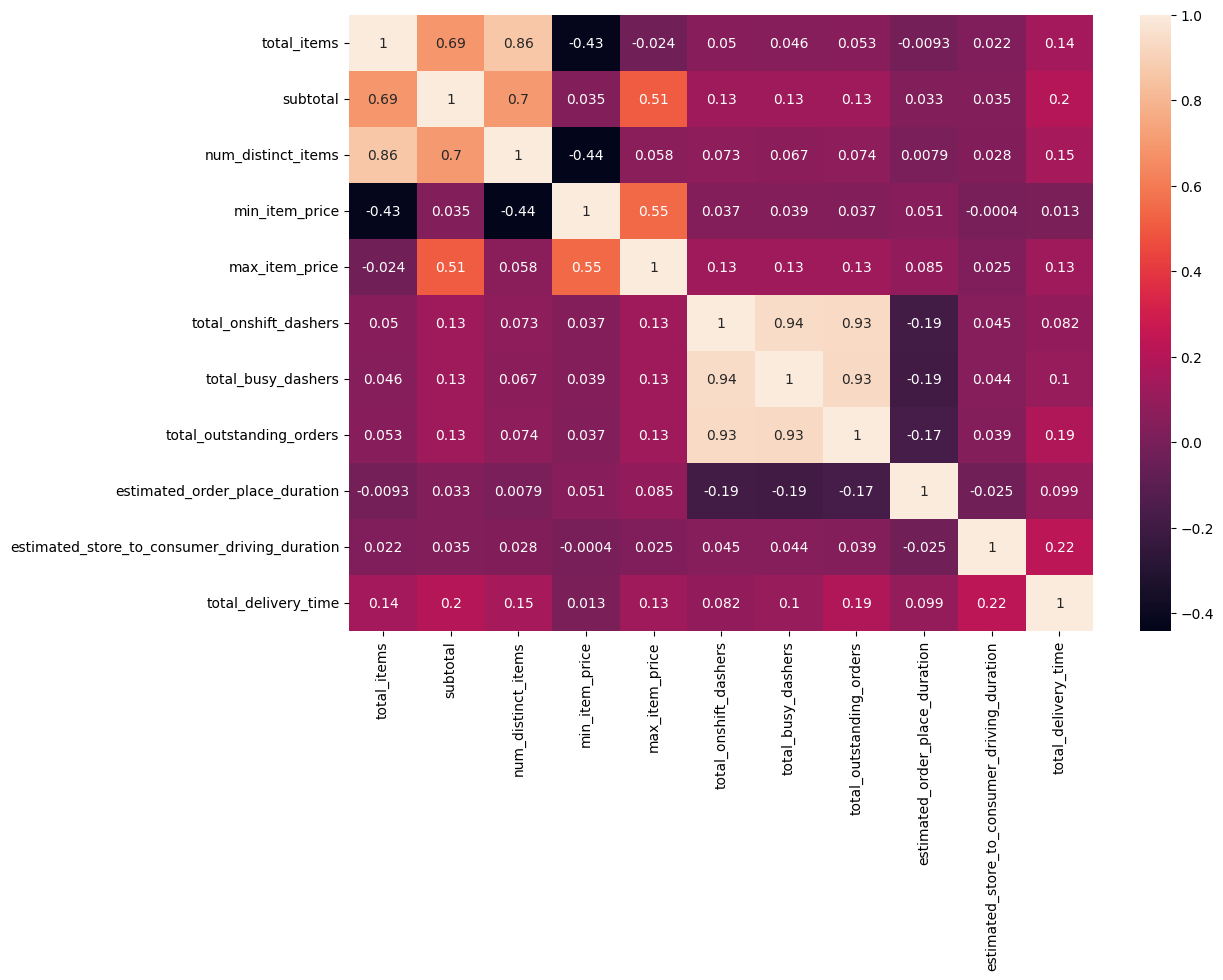

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(eda_df.corr(numeric_only=True), annot=eda_df.corr(numeric_only=True))

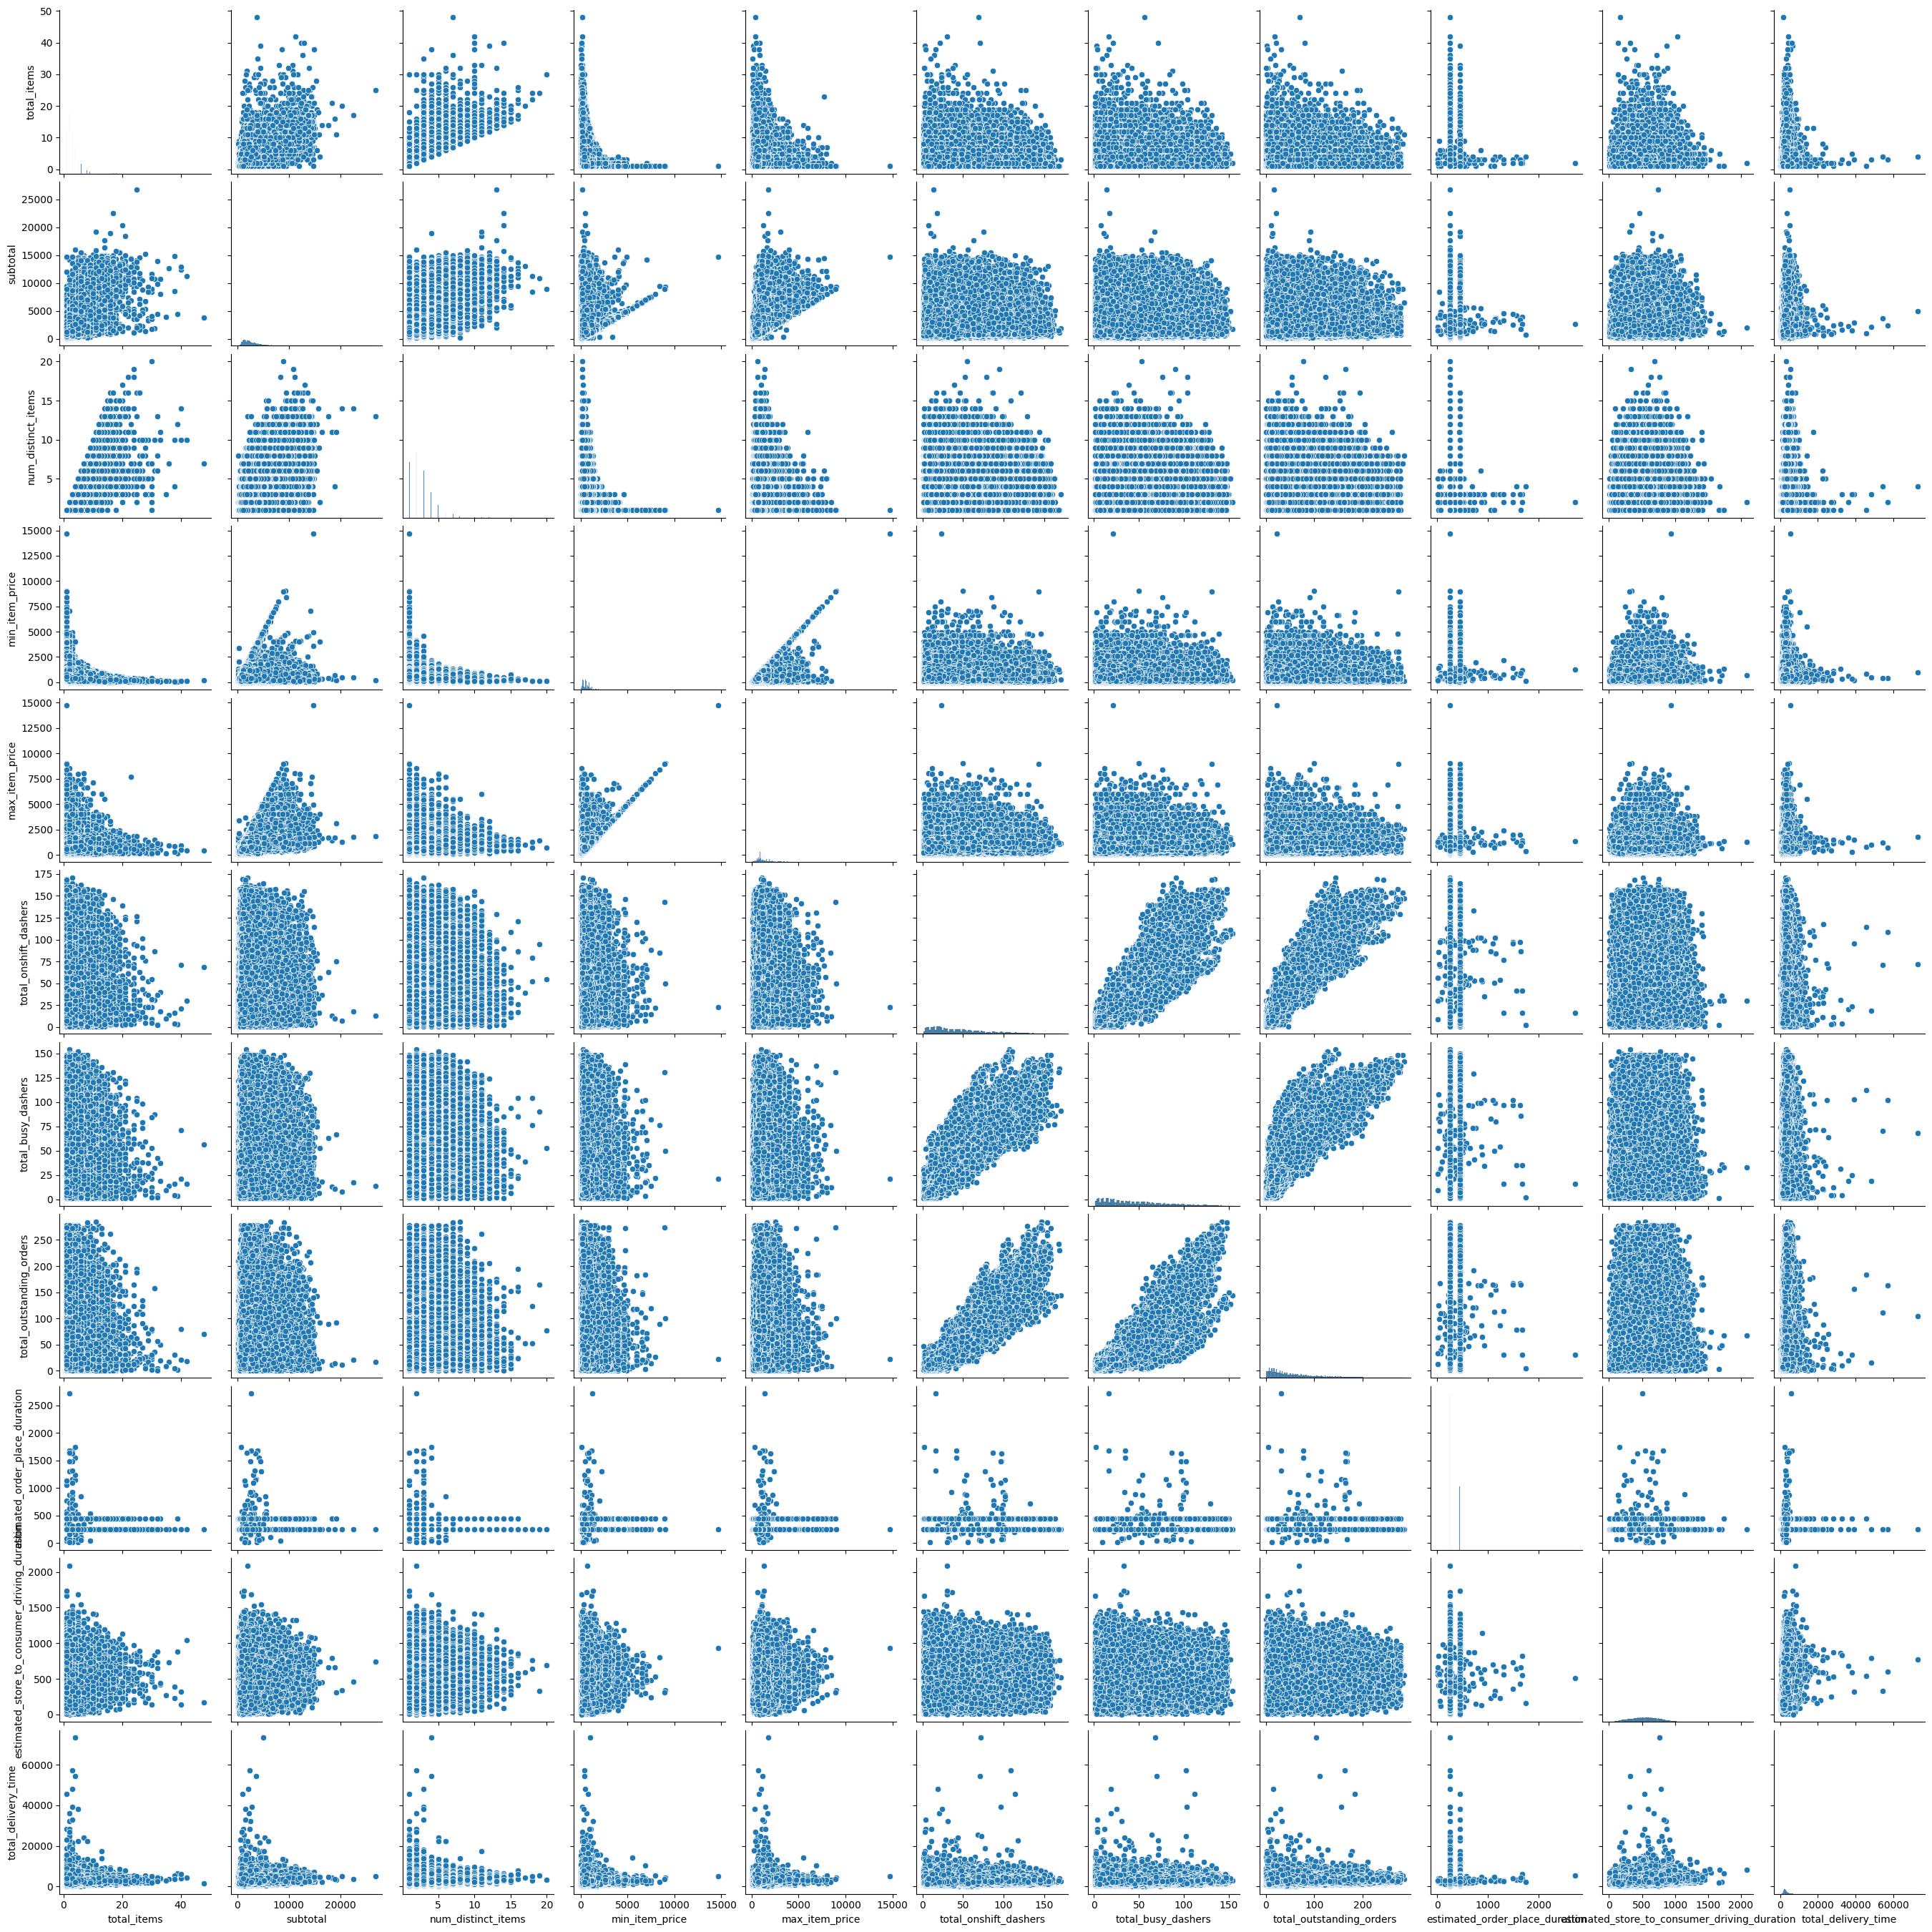

In [21]:
sns.pairplot(eda_df.loc[:, numerical_features])

#### Creating new Time Features

Lest create some time features based on `created_at` feature

In [22]:
eda_df["created_at"].apply(lambda x: x.hour)

0         22
1         21
8          0
14         3
15         2
          ..
197423     0
197424     0
197425     4
197426    18
197427    19
Name: created_at, Length: 169007, dtype: int64

In [23]:
eda_df["month"] = eda_df["created_at"].apply(lambda x: x.month)
eda_df["weekday"] = eda_df["created_at"].apply(lambda x: x.weekday())
eda_df["day"] = eda_df["created_at"].apply(lambda x: x.day)
eda_df["hour"] = eda_df["created_at"].apply(lambda x: x.hour)
eda_df.head()

market_id          created_at actual_delivery_time store_id  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16     1845   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29     5477   
8        2.0 2015-02-16 00:11:35  2015-02-16 00:38:01     5477   
14       1.0 2015-02-12 03:36:46  2015-02-12 04:14:39     2841   
15       1.0 2015-01-27 02:12:36  2015-01-27 03:02:24     2841   

   store_primary_category order_protocol  total_items  subtotal  \
0                american            1.0            4      3441   
1                 mexican            2.0            1      1900   
8                  indian            3.0            4      4771   
14                italian            1.0            1      1525   
15                italian            1.0            2      3620   

    num_distinct_items  min_item_price  ...  total_onshift_dashers  \
0                    4             557  ...                   33.0   
1                    1            1400  ...                    1.0   
8                    3             820  ...                    8.0   
14                   1            1525  ...                    5.0   
15                   2            1425  ...                    5.0   

    total_busy_dashers  total_outstanding_orders  \
0                 14.0                      21.0   
1                  2.0                       2.0   
8                  6.0                      18.0   
14                 6.0                       8.0   
15                 5.0                       7.0   

    estimated_order_place_duration  \
0                              446   
1                              446   
8                              446   
14                             446   
15                             446   

    estimated_store_to_consumer_driving_duration  total_delivery_time  month  \
0                                          861.0                 3779      2   
1                                          690.0                 4024      2   
8                                          289.0                 1586      2   
14                                         795.0                 2273      2   
15                                         205.0                 2988      1   

    weekday  day  hour  
0         4    6    22  
1         1   10    21  
8         0   16     0  
14        3   12     3  
15        1   27     2  

[5 rows x 21 columns]

#### Transforming Categorical Features

In this dataset we have onlu four categorical features :
- `market_id`
- `store_id` 
- `order_protocol`
- `store_primary_category`

`market_id` and `order_protocol` could be transformed using `One Hot Encoding`, because there is no order in these feature and few unique values.
For `store_id` and `store_primary_category` it is tough question, what encoding to use, because there is still no order on these features, but they have a lot of unique values, so `One Hot Encoding` will extend DataFrame, so we will use `Binary Encoding` for these features

In [50]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(sparse_output=False)

one_hot_features = ["market_id", "order_protocol"]

onehot_transformed = pd.DataFrame(onehotencoder.fit_transform(eda_df.loc[:, one_hot_features]), columns=onehotencoder.get_feature_names_out(), index=eda_df.index)
onehot_transformed

market_id_1.0  market_id_2.0  market_id_3.0  market_id_4.0  \
0                 1.0            0.0            0.0            0.0   
1                 0.0            1.0            0.0            0.0   
8                 0.0            1.0            0.0            0.0   
14                1.0            0.0            0.0            0.0   
15                1.0            0.0            0.0            0.0   
...               ...            ...            ...            ...   
197423            1.0            0.0            0.0            0.0   
197424            1.0            0.0            0.0            0.0   
197425            1.0            0.0            0.0            0.0   
197426            1.0            0.0            0.0            0.0   
197427            1.0            0.0            0.0            0.0   

        market_id_5.0  market_id_6.0  order_protocol_1.0  order_protocol_2.0  \
0                 0.0            0.0                 1.0                 0.0   
1                 0.0            0.0                 0.0                 1.0   
8                 0.0            0.0                 0.0                 0.0   
14                0.0            0.0                 1.0                 0.0   
15                0.0            0.0                 1.0                 0.0   
...               ...            ...                 ...                 ...   
197423            0.0            0.0                 0.0                 0.0   
197424            0.0            0.0                 0.0                 0.0   
197425            0.0            0.0                 0.0                 0.0   
197426            0.0            0.0                 1.0                 0.0   
197427            0.0            0.0                 1.0                 0.0   

        order_protocol_3.0  order_protocol_4.0  order_protocol_5.0  \
0                      0.0                 0.0                 0.0   
1                      0.0                 0.0                 0.0   
8                      1.0                 0.0                 0.0   
14                     0.0                 0.0                 0.0   
15                     0.0                 0.0                 0.0   
...                    ...                 ...                 ...   
197423                 0.0                 1.0                 0.0   
197424                 0.0                 1.0                 0.0   
197425                 0.0                 1.0                 0.0   
197426                 0.0                 0.0                 0.0   
197427                 0.0                 0.0                 0.0   

        order_protocol_6.0  order_protocol_7.0  
0                      0.0                 0.0  
1                      0.0                 0.0  
8                      0.0                 0.0  
14                     0.0                 0.0  
15                     0.0                 0.0  
...                    ...                 ...  
197423                 0.0                 0.0  
197424                 0.0                 0.0  
197425                 0.0                 0.0  
197426                 0.0                 0.0  
197427                 0.0                 0.0  

[169007 rows x 13 columns]

In [51]:
from category_encoders.binary import BinaryEncoder
binaryencoder = BinaryEncoder()

binary_features = ["store_id", "store_primary_category"]	

binary_transformed = pd.DataFrame(binaryencoder.fit_transform(eda_df.loc[:, binary_features]), columns=binaryencoder.get_feature_names_out(), index=eda_df.index)
binary_transformed

c:\delivery_duration_prediction\.venv\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\delivery_duration_prediction\.venv\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\delivery_duration_prediction\.venv\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .filln

store_id_0  store_id_1  store_id_2  store_id_3  store_id_4  \
0                0           0           0           0           0   
1                0           0           0           0           0   
8                0           0           0           0           0   
14               0           0           0           0           0   
15               0           0           0           0           0   
...            ...         ...         ...         ...         ...   
197423           1           0           1           0           1   
197424           1           0           1           0           1   
197425           1           0           1           0           1   
197426           1           0           1           0           1   
197427           1           0           1           0           1   

        store_id_5  store_id_6  store_id_7  store_id_8  store_id_9  \
0                0           0           0           0           0   
1                0           0           0           0           0   
8                0           0           0           0           0   
14               0           0           0           0           0   
15               0           0           0           0           0   
...            ...         ...         ...         ...         ...   
197423           0           0           1           1           0   
197424           0           0           1           1           0   
197425           0           0           1           1           0   
197426           0           0           1           1           0   
197427           0           0           1           1           0   

        store_id_10  store_id_11  store_id_12  store_primary_category_0  \
0                 0            0            1                         0   
1                 0            1            0                         0   
8                 0            1            0                         0   
14                0            1            1                         0   
15                0            1            1                         0   
...             ...          ...          ...                       ...   
197423            1            0            1                         0   
197424            1            0            1                         0   
197425            1            0            1                         0   
197426            1            1            0                         0   
197427            1            1            0                         0   

        store_primary_category_1  store_primary_category_2  \
0                              0                         0   
1                              0                         0   
8                              0                         0   
14                             0                         0   
15                             0                         0   
...                          ...                       ...   
197423                         0                         1   
197424                         0                         1   
197425                         0                         1   
197426                         0                         0   
197427                         0                         0   

        store_primary_category_3  store_primary_category_4  \
0                              0                         0   
1                              0                         0   
8                              0                         0   
14                             0                         1   
15                             0                         1   
...                          ...                       ...   
197423                         1                         0   
197424                         1                         0   
197425                         1                         0   
197426                         0                         1  

In [54]:
eda_df_tf = pd.concat([eda_df, onehot_transformed, binary_transformed], axis="columns").drop(binary_features + one_hot_features, axis="columns")
eda_df_tf

created_at actual_delivery_time  total_items  subtotal  \
0      2015-02-06 22:24:17  2015-02-06 23:27:16            4      3441   
1      2015-02-10 21:49:25  2015-02-10 22:56:29            1      1900   
8      2015-02-16 00:11:35  2015-02-16 00:38:01            4      4771   
14     2015-02-12 03:36:46  2015-02-12 04:14:39            1      1525   
15     2015-01-27 02:12:36  2015-01-27 03:02:24            2      3620   
...                    ...                  ...          ...       ...   
197423 2015-02-17 00:19:41  2015-02-17 01:24:48            3      1389   
197424 2015-02-13 00:01:59  2015-02-13 00:58:22            6      3010   
197425 2015-01-24 04:46:08  2015-01-24 05:36:16            5      1836   
197426 2015-02-01 18:18:15  2015-02-01 19:23:22            1      1175   
197427 2015-02-08 19:24:33  2015-02-08 20:01:41            4      2605   

        num_distinct_items  min_item_price  max_item_price  \
0                        4             557            1239   
1                        1            1400            1400   
8                        3             820            1604   
14                       1            1525            1525   
15                       2            1425            2195   
...                    ...             ...             ...   
197423                   3             345             649   
197424                   4             405             825   
197425                   3             300             399   
197426                   1             535             535   
197427                   4             425             750   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                        33.0                14.0                      21.0   
1                         1.0                 2.0                       2.0   
8                         8.0                 6.0                      18.0   
14                        5.0                 6.0                       8.0   
15                        5.0                 5.0                       7.0   
...                       ...                 ...                       ...   
197423                   17.0                17.0                      23.0   
197424                   12.0                11.0                      14.0   
197425                   39.0                41.0                      40.0   
197426                    7.0                 7.0                      12.0   
197427                   20.0                20.0                      23.0   

        ...  store_id_10  store_id_11  store_id_12  store_primary_category_0  \
0       ...            0            0            1                         0   
1       ...            0            1            0                         0   
8       ...            0            1            0                         0   
14      ...            0            1            1                         0   
15      ...            0            1            1                         0   
...     ...          ...          ...          ...                       ...   
197423  ...            1            0            1                         0   
197424  ...            1            0            1                         0   
197425  ...            1            0            1                         0   
197426  ...            1            1            0                         0   
197427  ...            1            1            0                         0   

        store_primary_category_1  store_primary_category_2  \
0                              0                         0   
1                              0                         0   
8                              0                         0   
14                             0                         0   
15                             0                         0   
...                          ...                       ...   
197423                         0      

#### New Correlations

<Axes: >

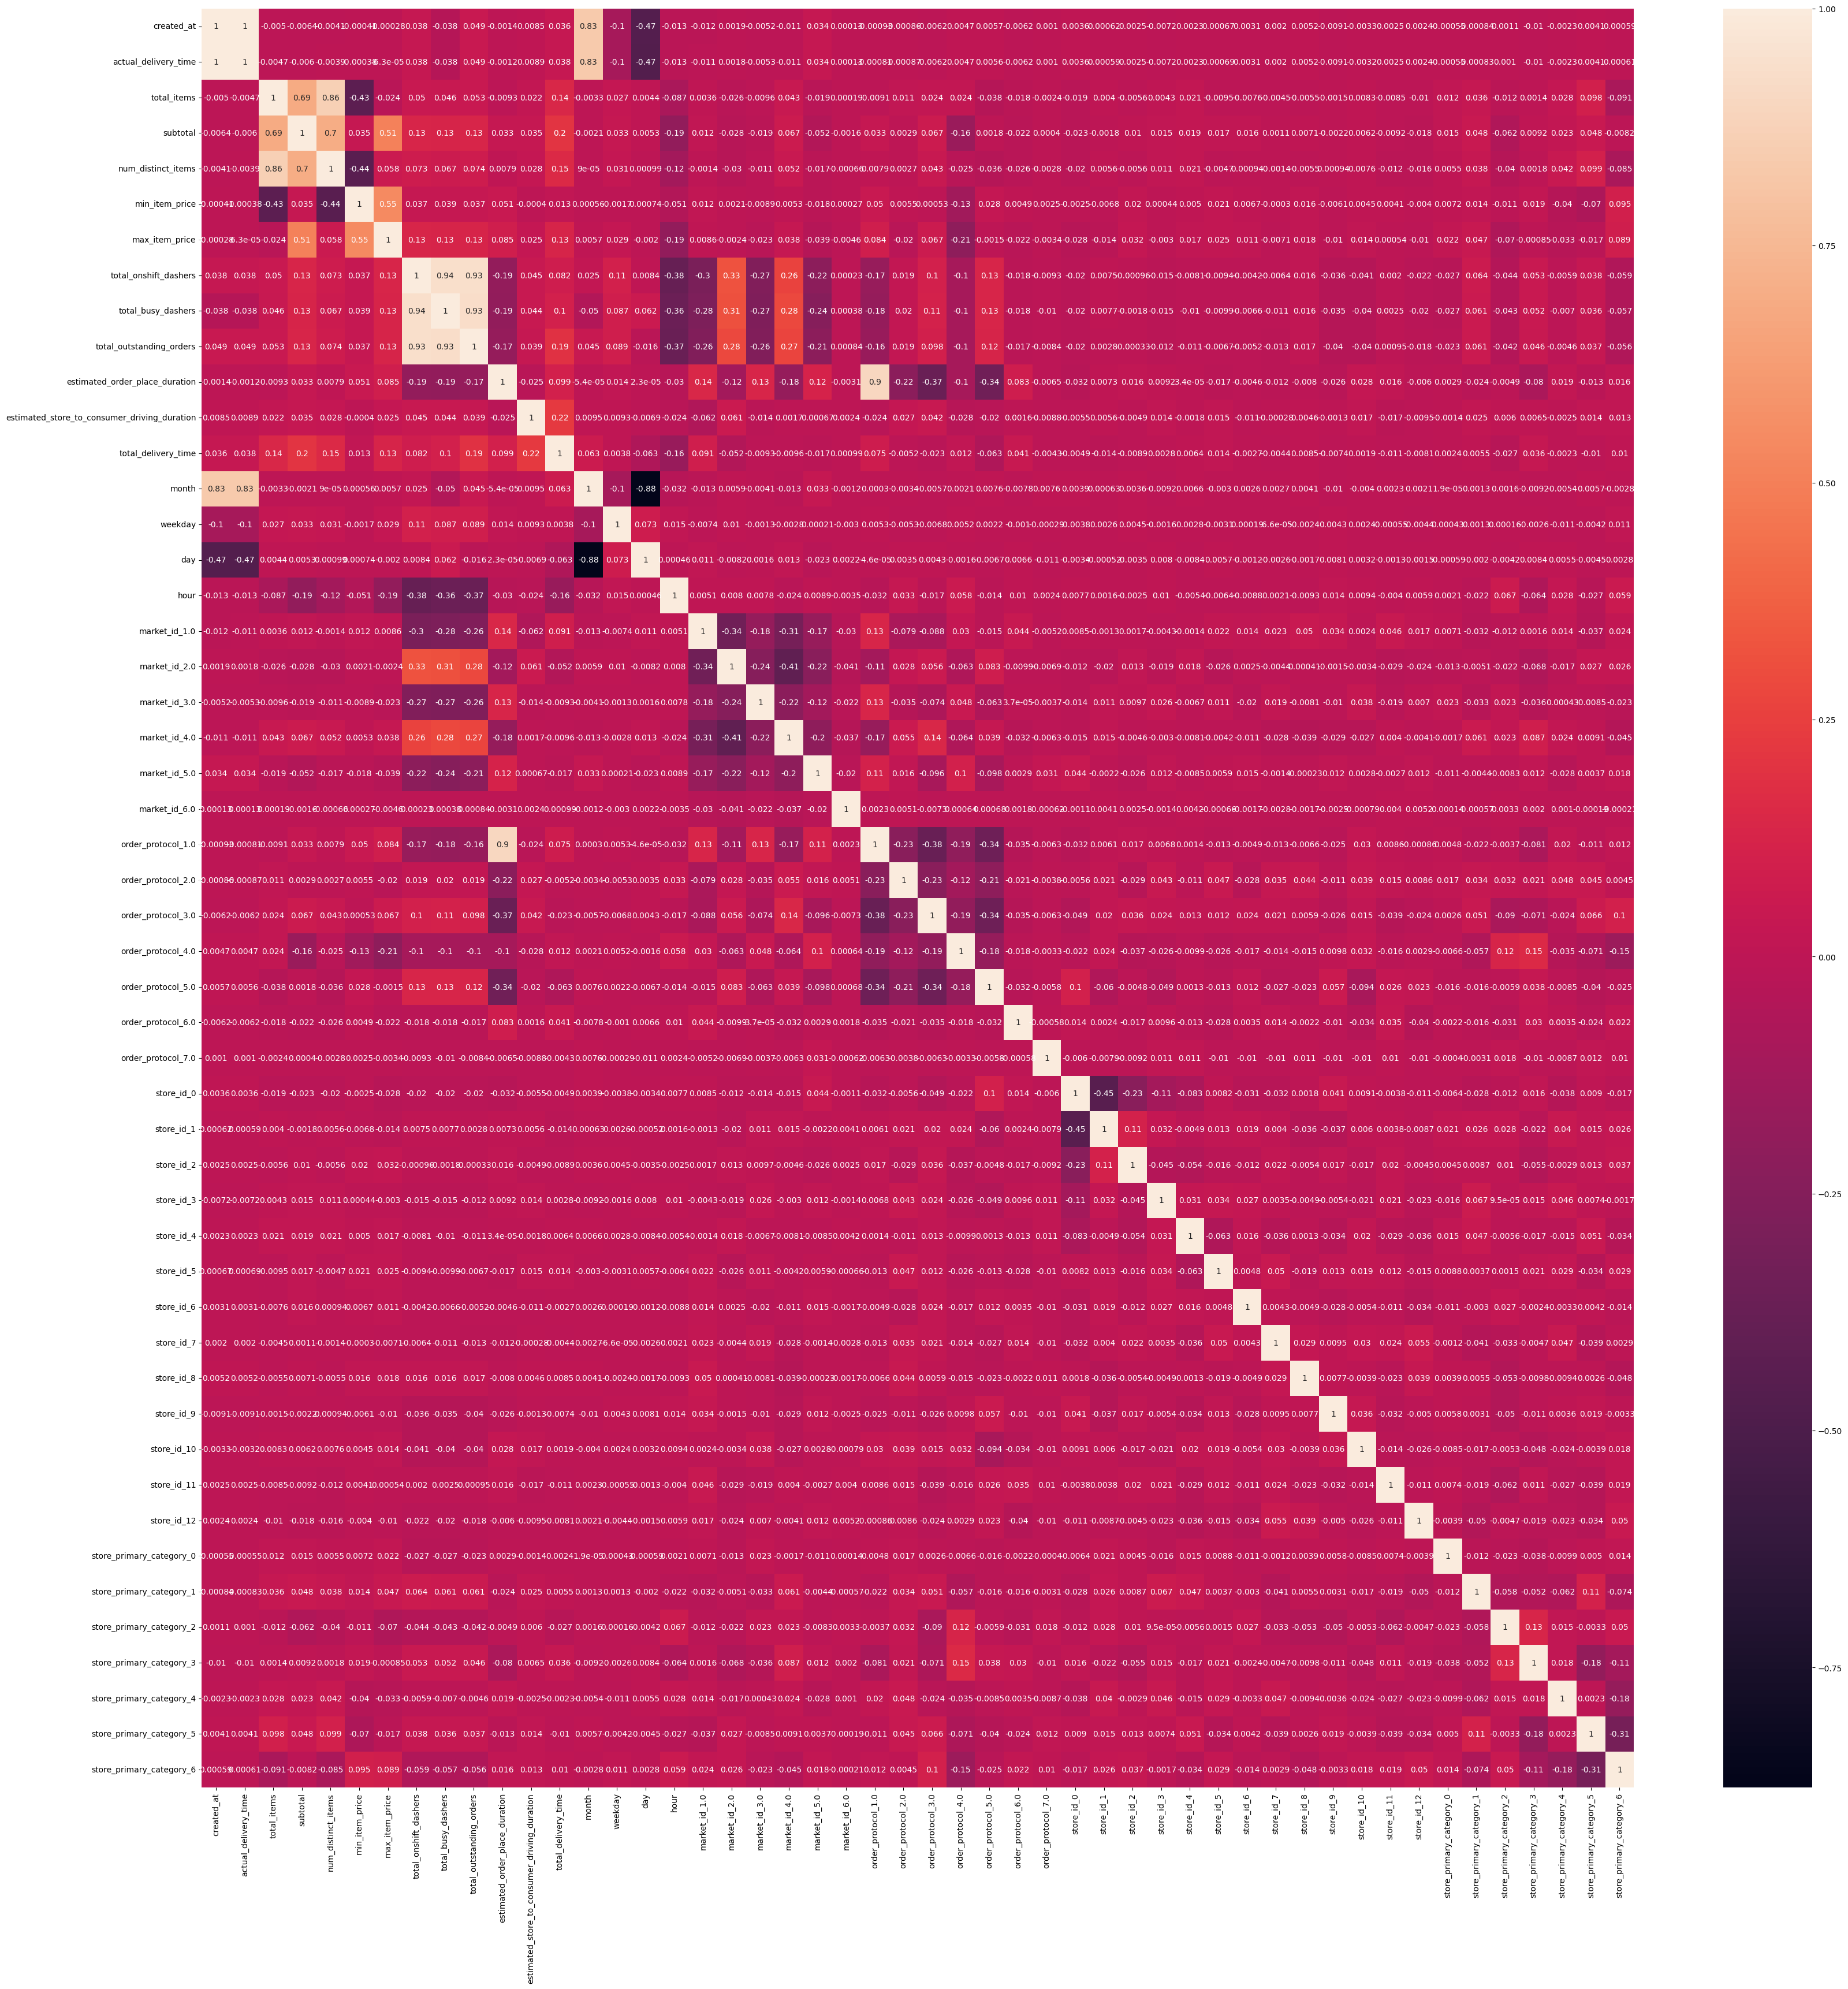

In [58]:
plt.figure(figsize=(40, 40))
sns.heatmap(eda_df_tf.corr(), annot=eda_df_tf.corr())

### Feature Selection

In order to select best features for this model, we will train `RandomForestRegression` on this dataset and check future inportances

In [61]:
from sklearn.ensemble import RandomForestRegressor

X = eda_df_tf.drop(["total_delivery_time", "created_at", "actual_delivery_time"], axis="columns")
y = eda_df_tf["total_delivery_time"]

model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=52)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances_df = pd.DataFrame({"Feature" : X.columns, "Importance" : feature_importances})
feature_importances_df = feature_importances_df.sort_values(by="Importance")

feature_importances_df	


Feature    Importance
26                            order_protocol_7.0  7.451857e-07
40                      store_primary_category_0  1.700879e-04
19                                 market_id_6.0  9.205403e-04
15                                 market_id_2.0  3.469653e-03
18                                 market_id_5.0  3.588926e-03
10                                         month  3.950367e-03
20                            order_protocol_1.0  4.214670e-03
41                      store_primary_category_1  4.937496e-03
25                            order_protocol_6.0  5.010766e-03
17                                 market_id_4.0  5.268280e-03
21                            order_protocol_2.0  5.996826e-03
24                            order_protocol_5.0  6.187829e-03
42                      store_primary_category_2  6.250476e-03
16                                 market_id_3.0  6.317291e-03
27                                    store_id_0  6.360149e-03
46                      store_primary_category_6  6.666230e-03
28                                    store_id_1  6.707309e-03
39                                   store_id_12  6.841830e-03
45                      store_primary_category_5  6.868274e-03
34                                    store_id_7  6.889447e-03
37                                   store_id_10  6.936330e-03
36                                    store_id_9  6.982284e-03
35                                    store_id_8  6.990711e-03
32                                    store_id_5  6.996229e-03
33                                    store_id_6  7.022459e-03
29                                    store_id_2  7.086785e-03
38                                   store_id_11  7.089749e-03
43                      store_primary_category_3  7.225662e-03
30                                    store_id_3  7.331075e-03
31                                    store_id_4  7.349405e-03
44                      store_primary_category_4  7.637134e-03
22                            order_protocol_3.0  8.049810e-03
23                            order_protocol_4.0  8.856077e-03
8                 estimated_order_place_duration  9.653450e-03
2                             num_distinct_items  1.697573e-02
14                                 market_id_1.0  1.729292e-02
0                                    total_items  1.736195e-02
6                             total_busy_dashers  4.840018e-02
11                                       weekday  4.864449e-02
3                                 min_item_price  5.684777e-02
4                                 max_item_price  6.510351e-02
12                                           day  6.972438e-02
5                          total_onshift_dashers  7.389890e-02
13                                          hour  7.919281e-02
7                       total_outstanding_orders  8.409703e-02
1                                       subtotal  9.714020e-02
9   estimated_store_to_consumer_driving_duration  1.234958e-01

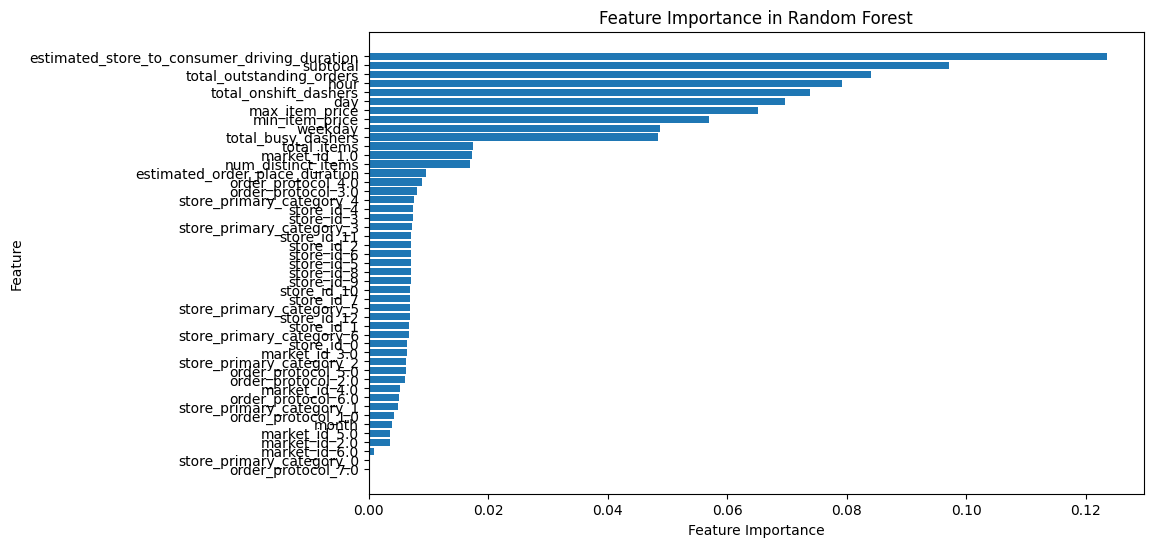

In [65]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()

Now, when we know influence of each feature on training, we can choose most valuable features

In [67]:
selected_features = list(feature_importances_df[feature_importances_df["Importance"] >= 0.01]["Feature"])
selected_features

['num_distinct_items',
 'market_id_1.0',
 'total_items',
 'total_busy_dashers',
 'weekday',
 'min_item_price',
 'max_item_price',
 'day',
 'total_onshift_dashers',
 'hour',
 'total_outstanding_orders',
 'subtotal',
 'estimated_store_to_consumer_driving_duration']